# Video compression

## Contents
1. [Sources of redundancy in video](#sources).
2. [Block-based motion compensation](#MC).
3. [Sub-pixel accuracy when estimating motion](#subpixel_accuracy).
4. [Block matching criteria](#matching_criteria).
5. [Block search strategies](#searching_strategies).
6. [Working with GOPs](#GOP_concept).
7. [MCTF (Motion Compensated Temporal Filtering)](#MCTF).
8. [An algorithm for block-based framed interpolation](#linear_frame_interpolation).
9. [Hybrid coding alternatives](#hybid_coding_alternatives).
10. [Deblocking filtering](#deblocking).
11. [Bit allocation strategies](#bit_allocation).
12. [Video scalability](#scalabilities).
13. [Encoding models](#models).

<a id='sources'></a>
## Sources of redundancy
1. **Spatial redundancy**: Pixels are very similar in its neighborhood or tends to repeat textures.
2. **Temporal redundancy**: Temporally adjacent images are typically very alike.
3. **Visual redundancy**: Humans hardly perceive high spatial and temporal frequencies (we like more low frequencies).

<a id='MC'></a>
## Block-based MC (Motion Compensation)

* Usually, only performed by the encoder (compress one. decompress many).
* MC removes temporal redundancy. A *predicted image* can be
  encoded as the difference between it and another image called
  *prediction image* which is a motion compensated projection of
  one or more images named *reference images*. ME tries to
  generate *residue images* as close as possible to the null
  images.
* For example, in the MPEG-1 standard, the reference image/s is/are divided in blocks of
  $16\times 16$ pixels called *macroblocks*.
* Each reference block is searched in the predicted image and the
  best match is indicated by mean of a *motion vector*.
* Depending on the success of the search and the number of
  reference images, the macroblocks are classified into:
  + **I (intra)**: When the compression of residue block generates more
    bits than the original (predicted) one.
  + **P (predicted)**: When it is better to compress the residue block and
    there is only one reference macroblock.
  + **B (bidirectionally predicted)**: The same, but if we have two reference macroblocks.
  + **S (skipped)**: When the energy of the residue block is
    smaller than a given threshold.
* I-pictures are composed of I macroblocks, only.
* P-pictures do not have B macrobocks.
* B-pictures can have any type of macroblocks.

<img src="figs/macroblocks.svg">

<a id='subpixel_accuracy'></a>
## Sub-pixel accuracy

* The motion estimation can be carried out using integer pixel
  accuracy or a fractional (sub-) pixel accuracy.
* For example, in MPEG-1, the motion estimation can have up to 1/2
  pixel accuracy. A bi-linear interpolator is used:

<img src="figs/interpolation.svg">

<a id='matching_criteria'></a>
## Matching criteria (similitude between macroblocks)

* Let $a$ and $b$ the macroblocks which we want to compare. Two
  main distortion metrics are commonly used:
  
  + **MSE (Mean Square Error)**:
  
    \begin{equation}
      \frac{1}{16\times 16}\sum_{i=1}^{16}\sum_{j=1}^{16}(a_{ij}-b_{ij})^2
    \end{equation}
    
  + **MAE (Mean Absolute Error)**:
  
    \begin{equation}
      \frac{1}{16\times 16}\sum_{i=1}^{16}\sum_{j=1}^{16}|a_{ij}-b_{ij}|
    \end{equation}

* These similitude measures are used only by MPEG
  compressors. Therefore, any other one with similar effects (such as
  the error variance or the error entropy) could be used also.

* Other less common distortion metrics that can work are:

  + **EE (Error [Entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory))**:

    \begin{equation}
      -\frac{1}{16\times 16}\sum_{i=1}^{16}\sum_{j=1}^{16}\log_2(a_{ij}-b_{ij})p(a_{ij}-b_{ij})
    \end{equation}


<a id='searching_strategies'></a>
## Searching strategies

* Only performed by the compressor.

    + **Full search**: All the possibilities are
    checked. Advantage: the best compression. Disadvantage: CPU
    killer.
    
    <img src="figs/full_search.svg">

    + ** Logaritmic search**: It is a version of the full search
    algorithm where the macro-blocks and the search area are
    sub-sampled. After finding the best coincidence, the resolution is increased in a power of 2 and the previous
    match is refined in a search area of $\pm 1$, until the maximal
    resolution (even using subpixel accuracy) is reached.
    
    <a id='telescopic_search'></a>
    + **Telescopic search**: Any of the previously described
    techniques can be speeded up if the searching area is
    reduced. This can be done supposing that the motion vector of the
    same macro-block in two consecutive images is similar.


<a id='searching_strategies'></a>
## The GOP (Group Of Pictures) concept

* The temporal redundancy is exploited by blocks of images called
  GOPs. This means that a GOP can be decoded independently of the rest
  of GOPs. Here an example:
  
<img src="figs/GOPs.svg">

<a id='MCTF'></a>
## MCTF (Motion Compensated Temporal Filtering)

* This is a DWT where the input samples are the original video
  images and the output is a sequence of residue images.
  
<img src="figs/MCTF.svg">

## $\pm 1$-spiral-search ME (Motion Estimation)
<img src="figs/spiral_search.svg" width=400>

<a id='linear_frame_interpolation'></a>
## Linear frame interpolation using block-based motion compensation

<img src="figs/frame_interpolation.svg">

### Input

* $R$: square search area, in pixels.
* $B$: square block size, in pixels.
* $O$: border size, in pixels.
* $s_i$, $s_j$ and $s_k$ three chronologically ordered, equidistant frames, with resolution $X\times Y$.
* $A$: $\frac{1}{2^A}$ subpixel accuracy.

### Output

* $\hat{s}_j$: a prediction for frame $s_j$.
* $m$: a matrix with $\lceil X/B\rceil \times \lceil Y/B\rceil$ bidirectional motion vectors.
* $e$: a matrix with $\lceil X/B\rceil \times \lceil Y/B\rceil$ bidirectional Root Mean Square matching Wrrors (RMSE).

### Algorithm

1. Compute the DWT$^l$, where $l=\lfloor\log_2(R)\rfloor-1$ levels, of the predicted frame $s_j$ and the two reference frames $s_i$ and $s_k$.
  <img src="figs/frame_interpolation_step_1.svg">
2. $LL^l(m)\leftarrow 0$, or any other precomputed values (for example, from a previous ME in neighbor frames).
  <img src="figs/frame_interpolation_step_2.svg" width=150>
3. Divide the subband $LL^l(s_j)$ into blocks of size $B\times B$ pixels, and $\pm 1$-spiral-search them in the subbands $LL^l(s_i)$ and $LL^l(s_k)$, calculating a low-resolution $LL^l(m)=\{LL^l(\overleftarrow{m}), LL^l(\overrightarrow{m})\}$ bi-directional motion vector field.
  <img src="figs/frame_interpolation_step_3A.svg">
  <img src="figs/frame_interpolation_step_3A_bis.svg" width=200>
4. While $l>0$:
  1. Synthesize $LL^{l-1}(m)$, $LL^{l-1}(s_j)$, $LL^{l-1}(s_i)$ and $LL^{l-1}(s_k)$, by computing the 1-level DWT$^{-1}$.
  <img src="figs/frame_interpolation_step_4A.svg">
  <img src="figs/frame_interpolation_step_4A_bis.svg" width=200>
  2. $LL^{l-1}(M)\leftarrow LL^{l-1}(M)\times 2$.
  <img src="figs/frame_interpolation_step_4B.svg" width=200>
  3. Refine $LL^{l-1}(m)$ using $\pm 1$-spiral-search.
  <img src="figs/frame_interpolation_step_4C.svg" width=200>
  4. $l\leftarrow l-1$. (When $l=0$, the motion vectors field $m$ has the structure:)
  <img src="figs/motion_vectors.svg" width=200>
4. While $l<A$ (in the first iteration, $l=0$, and $LL^0(M):=M$):
  1. $l\leftarrow l+1$.
  2. Synthesize $LL^{-l}(s_j)$, $LL^{-l}(s_i)$ and
    $LL^{-l}(s_k)$, computing the 1-level DWT$^{-1}$ (high-frequency subbands are $0$). This performs a zoom-in in these frames using $1/2$-subpixel accuracy.
    <img src="figs/frame_interpolation_step_5B.svg">
  3. $m\leftarrow m\times 2$.
     <img src="figs/motion_vectors_by_2.svg" width=210>
  4. $B\leftarrow B\times 2$.
  5. Divide the subband $LL^{-l}(s_j)$ into blocks of $B\times B$ pixels
    and $\pm 1$-spiral-search them into the subbands $LL^{-l}(s_i)$
    and $LL^{-l}(s_k)$, calculating a $1/2^l$ sub-pixel accuracy
    $m$ bi-directional motion vector field.
    <img src="figs/motion_vectors_definitive.svg" width=280>
1. Frame prediction. For each block $b$:
  1. Compute
    \begin{equation}
      \hat{b}\leftarrow \frac{b_i\big(\overleftarrow{e}_\text{max}-\overleftarrow{e}(b)\big) + b_k\big(\overrightarrow{e}_\text{max}-\overrightarrow{e}(b)\big)}{\big(\overleftarrow{e}_\text{max}-\overleftarrow{e}(b)\big) + \big(\overrightarrow{e}_\text{max}-\overrightarrow{e}(b)\big)},
    \end{equation}
    where $\overleftarrow{e}(b)$ is the (minimum) distortion of the best backward matching for block $b$, $\overrightarrow{e}(b)$ the (minimum) distortion of the best forward matching for block $b$, $\overleftarrow{e}_\text{max}=\overrightarrow{e}_\text{max}$ are the backward and forward maximum matching distortions, $b_i$ is the (backward) block found (as the most similar to $b$) in frame $s_i$ and $b_k$ is the (forward) block found in frame $s_k$. Notice that, if $\overleftarrow{e}(b)=\overrightarrow{e}(b)$, then the prediction is
    \begin{equation}
      \hat{b} = \frac{b_i + b_k}{2},
    \end{equation}
    and if $\overleftarrow{e}(b)=0$,
    \begin{equation}
      \hat{b} = b_k,
    \end{equation}
    and viceversa.

## Lab

Implement the [frame predictor](#linear_frame_interpolation) (work on https://github.com/Sistemas-Multimedia/MCDWT/blob/master/transform/mc/block/interpolate.py). Use https://github.com/Sistemas-Multimedia/MCDWT/blob/master/mcdwt/mc/block/interpolate.py and https://github.com/vicente-gonzalez-ruiz/MCTF-video-coding/blob/master/src/motion_estimate.cpp as reference.

## Lab

Compare the performance of the proposed matching strategies (MSE, MAE and EE) in the [frame predictor](#linear_frame_interpolation), by computing the variance of the prediction error between the original frame ($s_j$) and the prediction frame ($\hat{s}_j$).

## Lab

Test different DWT filters in the [frame predictor](#linear_frame_interpolation) and compare their performance. Compute the prediction error between the original frame ($s_j$) and the prediction frame ($\hat{s}_j$). Measure the dependency between this performance and the distance between frames ($i$, $j$, and $k$ indexes).

## Lab

Test the use of both the luma and the chroma in [frame predictor](#linear_frame_interpolation), and measure the performance of each option (only luma vs. all components), by computing the prediction error between the original frame ($s_j$) and the prediction frame ($\hat{s}_j$). Measure the dependency of the results with the distance between frames ($i$, $j$, and $k$ indexes).

## Lab

Analyze the impact of the $R$ (search range) parameter in the [frame predictor](#linear_frame_interpolation). Compute the prediction error between the original frame ($s_j$) and the prediction frame ($\hat{s}_j$). Study the impact of initializing the motion vectors ([telescopic search](#telescopic_search)). Measure the dependency with the distance between frames ($i$, $j$, and $k$ indexes).



<IPython.core.display.Math object>

<IPython.core.display.Math object>

2.000000	18.041096	9.846029	5.087060
4.000000	18.041096	9.846029	5.087060
8.000000	18.041096	9.846029	5.087060
16.000000	18.041096	9.846029	5.087060
32.000000	18.041096	9.846029	5.087060
64.000000	18.041096	9.846029	5.087060
128.000000	18.041096	9.846029	5.087060


Text(0,0.5,'Entropy')

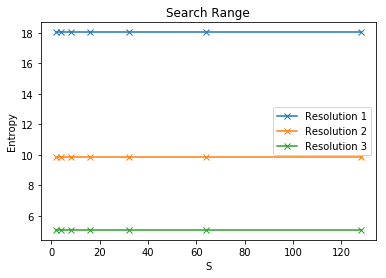

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex

entropyHight1=[(2, 18.041095837829808), (4, 18.041095837829808), (8, 18.041095837829808), (16, 18.041095837829808), (32, 18.041095837829808), (64, 18.041095837829808), (128, 18.041095837829808)]
entropyHight2=[(2, 9.846029243766116), (4, 9.846029243766116), (8, 9.846029243766116), (16, 9.846029243766116), (32, 9.846029243766116), (64, 9.846029243766116), (128, 9.846029243766116)]
entropyHight3=[(2, 5.087059993090022), (4, 5.087059993090022), (8, 5.087059993090022), (16, 5.087059993090022), (32, 5.087059993090022), (64, 5.087059993090022), (128, 5.087059993090022)]

display(Math(r'\text{Analyze Entropy by changing the parameter Search Range}'))
display(Math(r'Search Range\quad\quad\quad High_1\quad\quad\quad\quad High_2\quad\quad\quad\quad High_3'))

for i in range(0,len(entropyHight1),1):
    print("{:f}\t{:6f}\t{:6f}\t{:6f}".\
          format(entropyHight1[i][0], entropyHight1[i][1], entropyHight2[i][1], entropyHight3[i][1]))

entropyHight1X, entropyHight1Y = zip(*entropyHight1)
entropyHight2X, entropyHight2Y = zip(*entropyHight2)
entropyHight3X, entropyHight3Y = zip(*entropyHight3)

%matplotlib inline
fig, s = plt.subplots()
s.plot(entropyHight1X, entropyHight1Y,label="Resolution 1",marker='x')
s.plot(entropyHight2X, entropyHight2Y,label="Resolution 2",marker='x')
s.plot(entropyHight3X, entropyHight3Y,label="Resolution 3",marker='x')
s.legend()
s.set_title("Search Range")   
s.set_xlabel("S")   
s.set_ylabel("Entropy")  

## Lab

Analyze the impact of the $O$ (overlaping) parameter in the [frame predictor](#linear_frame_interpolation), by means of computing the prediction error between the original frame ($s_j$) and the prediction frame ($\hat{s}_j$). Measure the dependency with the distance between frames ($i$, $j$, and $k$ indexes).

## Lab

Analyze the impact of the $B$ (block size) parameter in the [frame predictor](#linear_frame_interpolation), by computing the prediction error between the original frame ($s_j$) and the prediction frame ($\hat{s}_j$). Compute the expected size of the motion fields using their 0-order entropy. Measure the dependency with the distance between frames ($i$, $j$, and $k$ indexes).

## Lab

Analyze the impact of the $A$ (subpixel accuracy) parameter in the [frame predictor](#linear_frame_interpolation), by computing the prediction error between the original frame ($s_j$) and the prediction frame ($\hat{s}_j$). Compute the expected size of the motion fields using their entropy. Measure the dependency with the distance between frames ($i$, $j$, and $k$ indexes).

<IPython.core.display.Math object>

<IPython.core.display.Math object>

1.000000   0.099390  0.293879  0.765173  0.455261  0.611766   0.725300  0.731728   0.697266  0.665301   0.656137
2.000000   0.181104  0.878652  0.988113  1.072572  1.046731   0.786234  0.748624   0.713472  0.692288   0.678808
3.000000   0.874122  1.307882  1.511335  0.982027  1.024325   0.790956  0.785012   0.759713  0.734755   0.720940


Text(0,0.5,'Entropy')

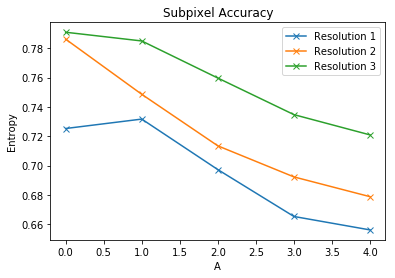

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex

sub0 = np.loadtxt('subpixel_analyze/motionhigh_entropy_0.txt')
sub1 = np.loadtxt('subpixel_analyze/motionhigh_entropy_1.txt')
sub2 = np.loadtxt('subpixel_analyze/motionhigh_entropy_2.txt')
sub3 = np.loadtxt('subpixel_analyze/motionhigh_entropy_3.txt')
sub4 = np.loadtxt('subpixel_analyze/motionhigh_entropy_4.txt')

sub1A = np.array([sub0[0][2],sub1[0][2],sub2[0][2],sub3[0][2],sub4[0][2]])
sub2A = np.array([sub0[1][2],sub1[1][2],sub2[1][2],sub3[1][2],sub4[1][2]])
sub3A = np.array([sub0[2][2],sub1[2][2],sub2[2][2],sub3[2][2],sub4[2][2]])

rl = np.array([sub0[0][0],sub0[1][0],sub0[2][0]])
m0 = np.array([sub0[0][1],sub0[1][1],sub0[2][1]])
h0 = np.array([sub0[0][2],sub0[1][2],sub0[2][2]])
m1 = np.array([sub1[0][1],sub1[1][1],sub1[2][1]])
h1 = np.array([sub1[0][2],sub1[1][2],sub1[2][2]])
m2 = np.array([sub2[0][1],sub2[1][1],sub2[2][1]])
h2 = np.array([sub2[0][2],sub2[1][2],sub2[2][2]])
m3 = np.array([sub3[0][1],sub3[1][1],sub3[2][1]])
h3 = np.array([sub3[0][2],sub3[1][2],sub3[2][2]])
m4 = np.array([sub4[0][1],sub4[1][1],sub4[2][1]])
h4 = np.array([sub4[0][2],sub4[1][2],sub4[2][2]])


display(Math(r'\text{Analyze Entropy by changing the parameter Subpixel Search}'))
display(Math(r'Resolution\quad Motion_0\quad Motion_1\quad Motion_2\quad Motion_3\quad Motion_4\quad\quad  High_0\quad\quad High_1\quad\quad High_2\quad\quad High_3\quad\quad High_4'))
print("{:f}   {:6f}  {:6f}  {:6f}  {:6f}  {:6f}   {:6f}  {:6f}   {:6f}  {:6f}   {:6f}".\
          format(sub0[0][0], sub0[0][1], sub1[0][1], sub2[0][1],sub3[0][1],sub4[0][1],sub0[0][2], sub1[0][2], sub2[0][2],sub3[0][2],sub4[0][2]))

print("{:f}   {:6f}  {:6f}  {:6f}  {:6f}  {:6f}   {:6f}  {:6f}   {:6f}  {:6f}   {:6f}".\
          format(sub0[1][0], sub0[1][1], sub1[1][1], sub2[1][1],sub3[1][1],sub4[1][1],sub0[1][2], sub1[1][2], sub2[1][2],sub3[1][2],sub4[1][2]))

print("{:f}   {:6f}  {:6f}  {:6f}  {:6f}  {:6f}   {:6f}  {:6f}   {:6f}  {:6f}   {:6f}".\
          format(sub0[2][0], sub0[2][1], sub1[2][1], sub2[2][1],sub3[2][1],sub4[2][1],sub0[2][2], sub1[2][2], sub2[2][2],sub3[2][2],sub4[2][2]))

%matplotlib inline
fig, s = plt.subplots()
s.plot(sub1A,label="Resolution 1",marker='x')
s.plot(sub2A,label="Resolution 2",marker='x')
s.plot(sub3A,label="Resolution 3",marker='x')
s.legend()
s.set_title("Subpixel Accuracy")   
s.set_xlabel("A")   
s.set_ylabel("Entropy")  

## Lab

Compare the performance of the [frame predictor](#linear_frame_interpolation) when it holds that

\begin{equation}
   \hat{b} = \frac{b_i + b_k}{2},
\end{equation}

for all blocks.

<a id='hybid_coding_alternatives'></a>
## MC/DWT hybrid coding alternatives

* **t+2d**: The sequence of images is decorrelated first
  along the time (t) and the residue images are compressed, exploiting
  the remaining spatial (2d) redundancy. Examples: MPEG* and H.26*
  codecs (except H.264/SVC).
  
* **2d+t**: The spatial (2d) redudancy is explited first
  (using typically the DWT) and after that, the coefficients are decorrelated
  along the time (t). For now, this has only been an experimental setup
  because most DWT transformed domains are not invariant to the
  displacement, and therefore, ME/MC can not be directly applied.
  
* **2d+t+2d**: The fist step creates a Laplacian Pyramid
  (2d), which is invariant to the displacement. Next, each level of
  the pyramid is decorrelated along the time (t) and finally, the
  remaining spatial redundancy is removed (2d). Example: H.264/SVC.

<img src="figs/H264-S-SVC.svg">

<a id='deblocking'></a>
## Deblocking filtering

* If any other block-overlaping techniques have not been applied, block-based video encoders improve their performance if a deblocking filter in used to create the quantized prediction predictions.
  
<img src="figs/350px-Deblock1.jpg" width=600>

* The low-pass filter is applied only on the block boundaries.

<a id='bit_allocation'></a>
## Bit-rate allocation

* VBR: Under a constant quantization level (constant video quality),
  the number of bits that each compressed image needs depends on the
  image content (Variable Bit-Rate). Example:

  <img src="figs/closed-loop-1_ir.svg">
  
* CBR: Using a Constant Bit-Rate strategy, all frames need the same space. Example:

  <img src="figs/CBR.svg">

<a id='scalabilities'></a>
## Video scalability

### Quality scalability

<img src="figs/quality-scalability.svg">

* Ideal for remote visualization environments.

* By definition, $s^{[0]}:=s$.

### Temporal scalability

<img src="figs/temporal-scalability.svg">

* It holds that

  \begin{equation}
    s^{t}=\{s_{2^t i}\}=\{s_{2i}^{t-1}\},
  \end{equation}
  
  where $t$ denotes the Temporal Resolution Level (TRL).

* Notice that $s:=s^{0}$.

* Useful for fast random access.

### Spatial scalability

  <img src="figs/spatial-scalability.svg">

* Useful for low-resolution devices.

* By definition, $V_i:=V_i^{<0>}$ and $V_i^{<s>}$ has a
  $\frac{Y}{2^s}\times \frac{X}{2^s}$ resolution, where $X\times Y$ is
  the resolution of $V_i$.

<a id='models'></a>
## Media encoding models

<img src="figs/media-encoding-models.svg" width=400>

#### Single Layer Coding (SLC)

* Most audio and image/video codecs generate non-scalable
  streams. In the case of video, only one quality, resolution and
  picture-rate are available at decoding time.
  
* The decoding of a single layered stream generates a
  reconstruction whose quality is linearly proportional to the amount
  of decoded data.
  
#### [Multiple Layer Coding (MLC)](http://eeweb.poly.edu/~yao/EL6123/scalablecoding.pdf)

* A media encoded in several layers can be decoded to provide (in
  the case of video) different picture-rates (time scalability),
  different resolutions (spatial scalability) and different qualities
  (quality scalability).
  
* In some codecs (such as JPEG 2000), spatial random access it is
  available ROI (Region-Of-Interest) or WOI (Window-Of-Interest)
  scalability. ROI is used in special imaging, such as [mammography](http://en.wikipedia.org/wiki/Mammography). WOI can
  useful in the retrieving of high-resolution video sequences such as [JHelioviewer](http://jhelioviewer.org/linux.html).
  
#### [Multiple Description Coding (MDC)](http://en.wikipedia.org/wiki/Multiple_description_coding)

* Multiple description codecs provides a set of
  partially redundant streams so that the quality of the reconstructions
  improve with the number of descriptions decoded.
  
* An example of this type of encoding is the scene segmentation
  (video object coding) provided by [MPEG-4](http://www.cs.cf.ac.uk/Dave/MM/BSC_MM_CALLER/PDF/12_CM340_MPEG4_VIDEO.pdf).
  
#### [Media simulcast](http://en.wikipedia.org/wiki/Simulcast)

* In transmission scenarios, a source can store several copies of
  the same media, althought variying the temporal resolution, spatial
  resolution and/or quality.
  
* Obviously, this is quite redundant at the source side. However,
  adaptive services can be provided with
  this technique, such as in YouTube which uses [DASH](https://en.wikipedia.org/wiki/Dynamic_Adaptive_Streaming_over_HTTP).